In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed.knee_locator import KneeLocator

In [2]:
df = pd.read_csv('data/adult19.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 130.4+ MB


In [4]:
# those that feel depressed at least on a weekly basis
df_depressed = df[df.DEPFREQ_A <= 2].copy()

In [5]:
df_depressed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 12.7+ MB


In [6]:
depressed_vars = pd.read_csv('dep_vars.csv')

In [7]:
depressed_core = df_depressed[depressed_vars.Variable].copy()

In [8]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DEPEV_A     3118 non-null   int64  
 1   DEPFREQ_A   3118 non-null   int64  
 2   DEPMED_A    3118 non-null   int64  
 3   DEPLEVEL_A  3118 non-null   float64
 4   PHQ81_A     3118 non-null   int64  
 5   PHQ82_A     3118 non-null   int64  
 6   PHQ83_A     3118 non-null   int64  
 7   PHQ84_A     3118 non-null   int64  
 8   PHQ85_A     3118 non-null   int64  
 9   PHQ86_A     3118 non-null   int64  
 10  PHQ87_A     3118 non-null   int64  
 11  PHQ88_A     3118 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 316.7 KB


In [9]:
depressed_core.columns

Index(['DEPEV_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'PHQ81_A', 'PHQ82_A',
       'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A'],
      dtype='object')

According to the codebook, DEPEV_A is the response to the question: "Have you ever been told by a doctor or health professional that you had ...any type of depression?" The values DEPEV_A can take are: 1, yes; 2, no, 7, refused; 8, not ascertained; and 9 , don't know.  Labeling the values and then creating a countplot...  

<AxesSubplot:xlabel='DEPEV_A', ylabel='count'>

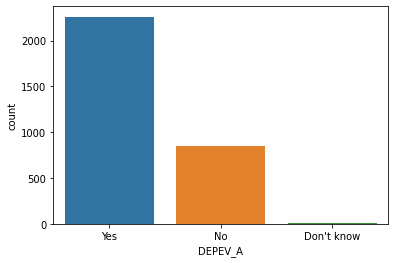

In [10]:
labels = {1:'Yes', 2: 'No', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPEV_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPEV_A', data = depressed_core)

The majority have been diagnosed as depressed although over 500 have not been told by a doctor they have depression.  To reduce the number of columns when one hot encoding, I'm going to replace yes with 1, no with -1, and don't know with 0


In [11]:
labels = {'Yes':1,'No':-1,"Don't know":0}
depressed_core.DEPEV_A.replace(labels, inplace=True)

DEPFREQ_A is the response to the question "How often do you feel depressed?" The values DEPFREQ_A can take are: 1, daily; 2, weekly; 3, monthly; 4, a few times a year; 5 never; 7, refused; 8, not ascertained; 9, don't know.  Earlier I filtered the dataframe to only include values of 1 or 2.  Renaming the labels and creating a countplot... 

<AxesSubplot:xlabel='DEPFREQ_A', ylabel='count'>

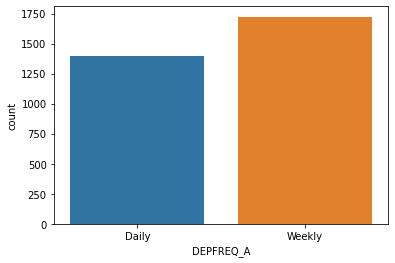

In [12]:
labels = {1:'Daily',2:'Weekly'}
depressed_core.DEPFREQ_A.replace(labels,inplace=True)
sns.countplot(x='DEPFREQ_A', data=depressed_core)

As you can see more feel depression on a weekly basis but it close to even.

DEPMED_A represents respondants to the question, "Do you take prescription medication for depression?"  The values are: 1, yes; 2, no; 7, refused; 8, not ascertained; and 9, don't know.

<AxesSubplot:xlabel='DEPMED_A', ylabel='count'>

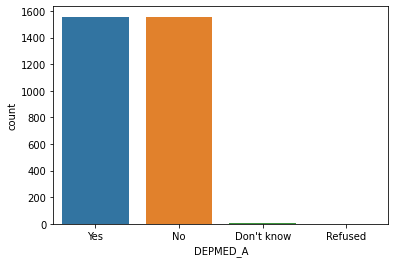

In [13]:
labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
depressed_core.DEPMED_A.replace(labels,inplace=True)
sns.countplot(x='DEPMED_A',data=depressed_core)

An equal amount of those feeling depression take and do not take medication for depression.  
I am going to combine 'Don't know' and Refused into an 'Other' category.  Then I will set 'yes' to 1, 'no' to -1 and 'other' to 0 to reduce the number of features when the data gets one hot encoded.

In [14]:
labels = {"Don't know":'Other','Refused':'Other'}
depressed_core.DEPMED_A.replace(labels,inplace=True)
labels = {'Yes':1,'No':-1,'Other':0}
depressed_core.DEPMED_A.replace(labels,inplace=True)

DEPLEVEL_A is the respondants answer to the question, "Thinking about the last time you felt depressed, how depressed did you feel?  Would you say a little, a lot, or somewhere in between?".  Values represented: 1, a little; 2, a lot; 3, somewhere in between a little and a lot; 7, refused; 8, not ascertained; 9, don't know. 

<AxesSubplot:xlabel='DEPLEVEL_A', ylabel='count'>

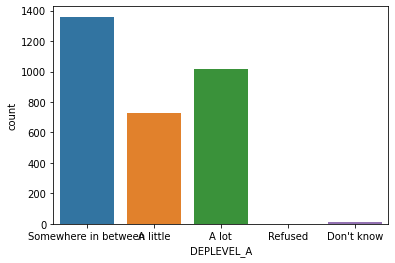

In [15]:
labels = {1: 'A little', 2: 'A lot', 3: 'Somewhere in between', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPLEVEL_A', data = depressed_core)

The majority feel somewhere in between a little and a lot. 
Again I am going to combine refused and Don't know into an other category

In [16]:
labels = {'Refused':"Other","Don't know":"Other"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)


PHQ81_A holds responses from the question, "Over the last two weeks how often have you been bothered by little interest or pleasure in doing things?" Responses include: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; 9, don't know.

<AxesSubplot:xlabel='PHQ81_A', ylabel='count'>

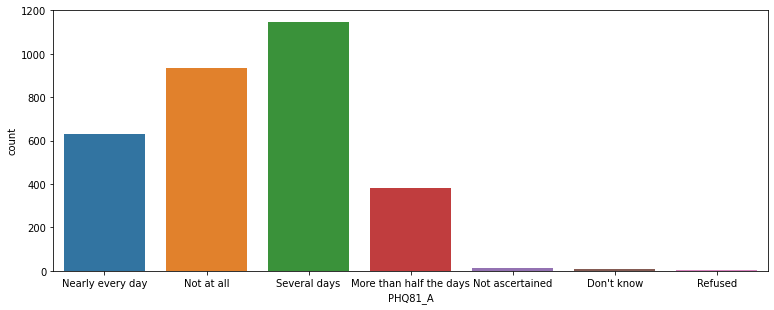

In [17]:
labels = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ81_A.replace(labels, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ81_A', data=depressed_core)

The majority of those facing depression feels bothered by little interest or pleasure several days. I am going to combine Not ascertained, don't know and refused into an other category 

In [18]:
labels_other = {"Don't know":'Other',"Refused":'Other',"Not ascertained":'Other'}
depressed_core.PHQ81_A.replace(labels_other, inplace=True)

PHQ82_A holds the answer to: in the past two weeks, how often have you been bothered by feeling down, depressed or hopeless?
The data can take on values: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; or 9, don't know.

<AxesSubplot:xlabel='PHQ82_A', ylabel='count'>

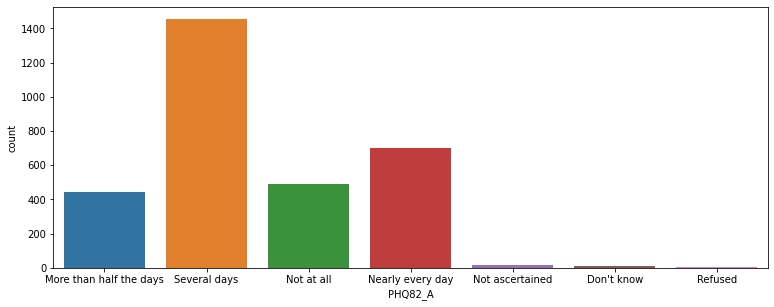

In [19]:
labels_ntostr = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ82_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ82_A', data=depressed_core)


Again most felt down several days.  And again, those will a small amount of values, I am placing in one bucket, 'other'

In [20]:
depressed_core.PHQ82_A.replace(labels_other, inplace=True)

PHQ83_A indicates how often in the past two weeks people have been bothered by trouble falling asleep, trouble staying aslepp, or sleeping too much.

<AxesSubplot:xlabel='PHQ83_A', ylabel='count'>

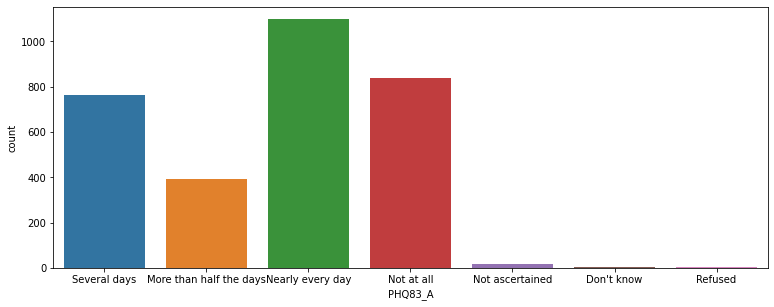

In [21]:
depressed_core.PHQ83_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ83_A', data=depressed_core)

In this case the majority of those with depression have been feeling bothered by trouble with sleep nearly every day

In [22]:
depressed_core.PHQ83_A.replace(labels_other, inplace=True)

PHQ84_A records responses to the question on over the past two weeks how often have you been bothered by feeling tired or having little energy.

<AxesSubplot:xlabel='PHQ84_A', ylabel='count'>

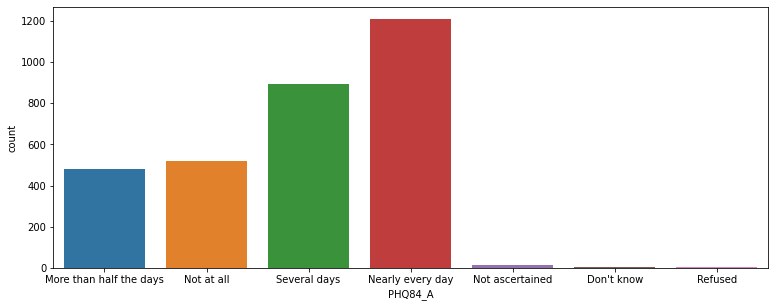

In [23]:
depressed_core.PHQ84_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ84_A', data=depressed_core)


Notice most have trouble with energy levels nearly every day.



In [24]:
depressed_core.PHQ84_A.replace(labels_other, inplace=True)

PHQ85_A reports how many times in the past two weeks have people been bothered by a poor appetite or overeating.

<AxesSubplot:xlabel='PHQ85_A', ylabel='count'>

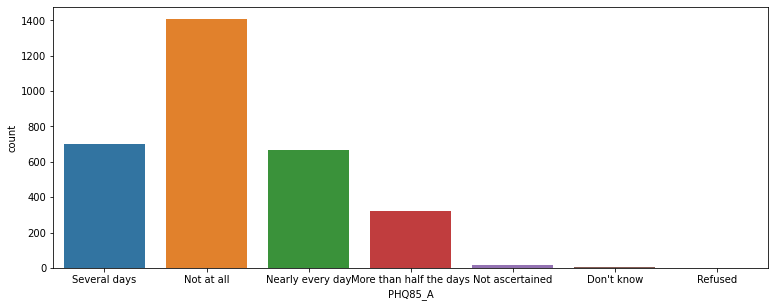

In [25]:
depressed_core.PHQ85_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ85_A', data=depressed_core)

The majority were not at all bothered by over or under eating.



In [26]:
depressed_core.PHQ85_A.replace(labels_other, inplace=True)

PHQ86_A reports how many times over the past two weeks, people have been bothered by feeling bad about themselves.

<AxesSubplot:xlabel='PHQ86_A', ylabel='count'>

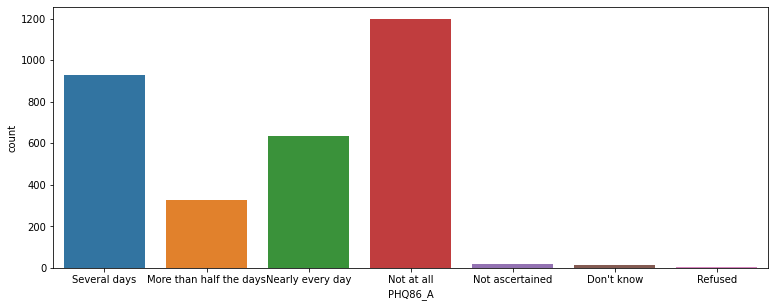

In [27]:
depressed_core.PHQ86_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ86_A', data=depressed_core)

As can be seen there is a split between several days or not at all.



In [28]:
depressed_core.PHQ86_A.replace(labels_other, inplace=True)

PHQ87_A reports how many times over the past few weeks people have been bothered by trouble concentrating

<AxesSubplot:xlabel='PHQ87_A', ylabel='count'>

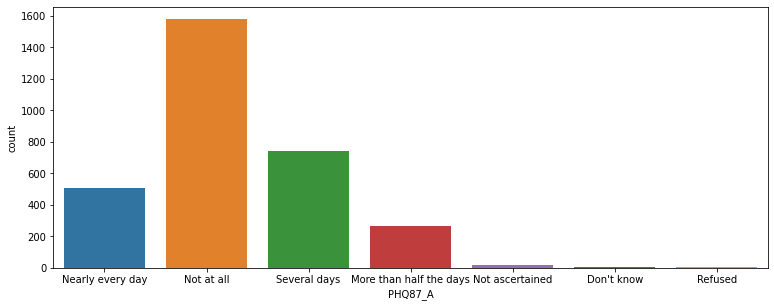

In [29]:
depressed_core.PHQ87_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ87_A', data=depressed_core)

Most were not bothered by trouble concentrating



In [30]:
depressed_core.PHQ87_A.replace(labels_other, inplace=True)

PHQ88_A asks how often in the past few weeks people were bothered by moving or speaking slow or fast.

<AxesSubplot:xlabel='PHQ88_A', ylabel='count'>

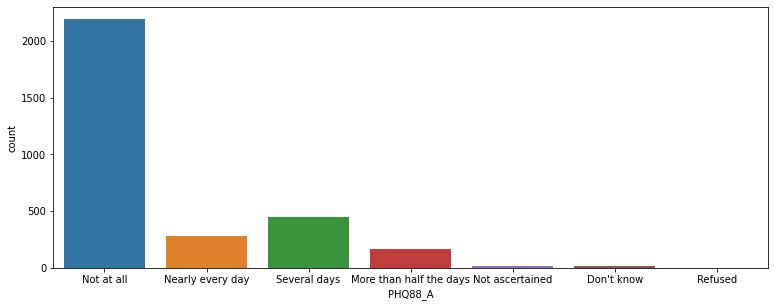

In [31]:
depressed_core.PHQ88_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ88_A', data=depressed_core)

The clear majority is not at all.  Because of this I'm going to drop PHQ88_A

In [32]:
depressed_core.drop('PHQ88_A',axis=1, inplace=True)

In [33]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DEPEV_A     3118 non-null   int64 
 1   DEPFREQ_A   3118 non-null   object
 2   DEPMED_A    3118 non-null   int64 
 3   DEPLEVEL_A  3118 non-null   object
 4   PHQ81_A     3118 non-null   object
 5   PHQ82_A     3118 non-null   object
 6   PHQ83_A     3118 non-null   object
 7   PHQ84_A     3118 non-null   object
 8   PHQ85_A     3118 non-null   object
 9   PHQ86_A     3118 non-null   object
 10  PHQ87_A     3118 non-null   object
dtypes: int64(2), object(9)
memory usage: 356.9+ KB


In [34]:
df_depressed_core = pd.get_dummies(depressed_core)
df_depressed_core.shape

(3118, 43)

# Checking for correlated features 

When calculating distance the features that are very similar are going to be weighted more.

<AxesSubplot:>

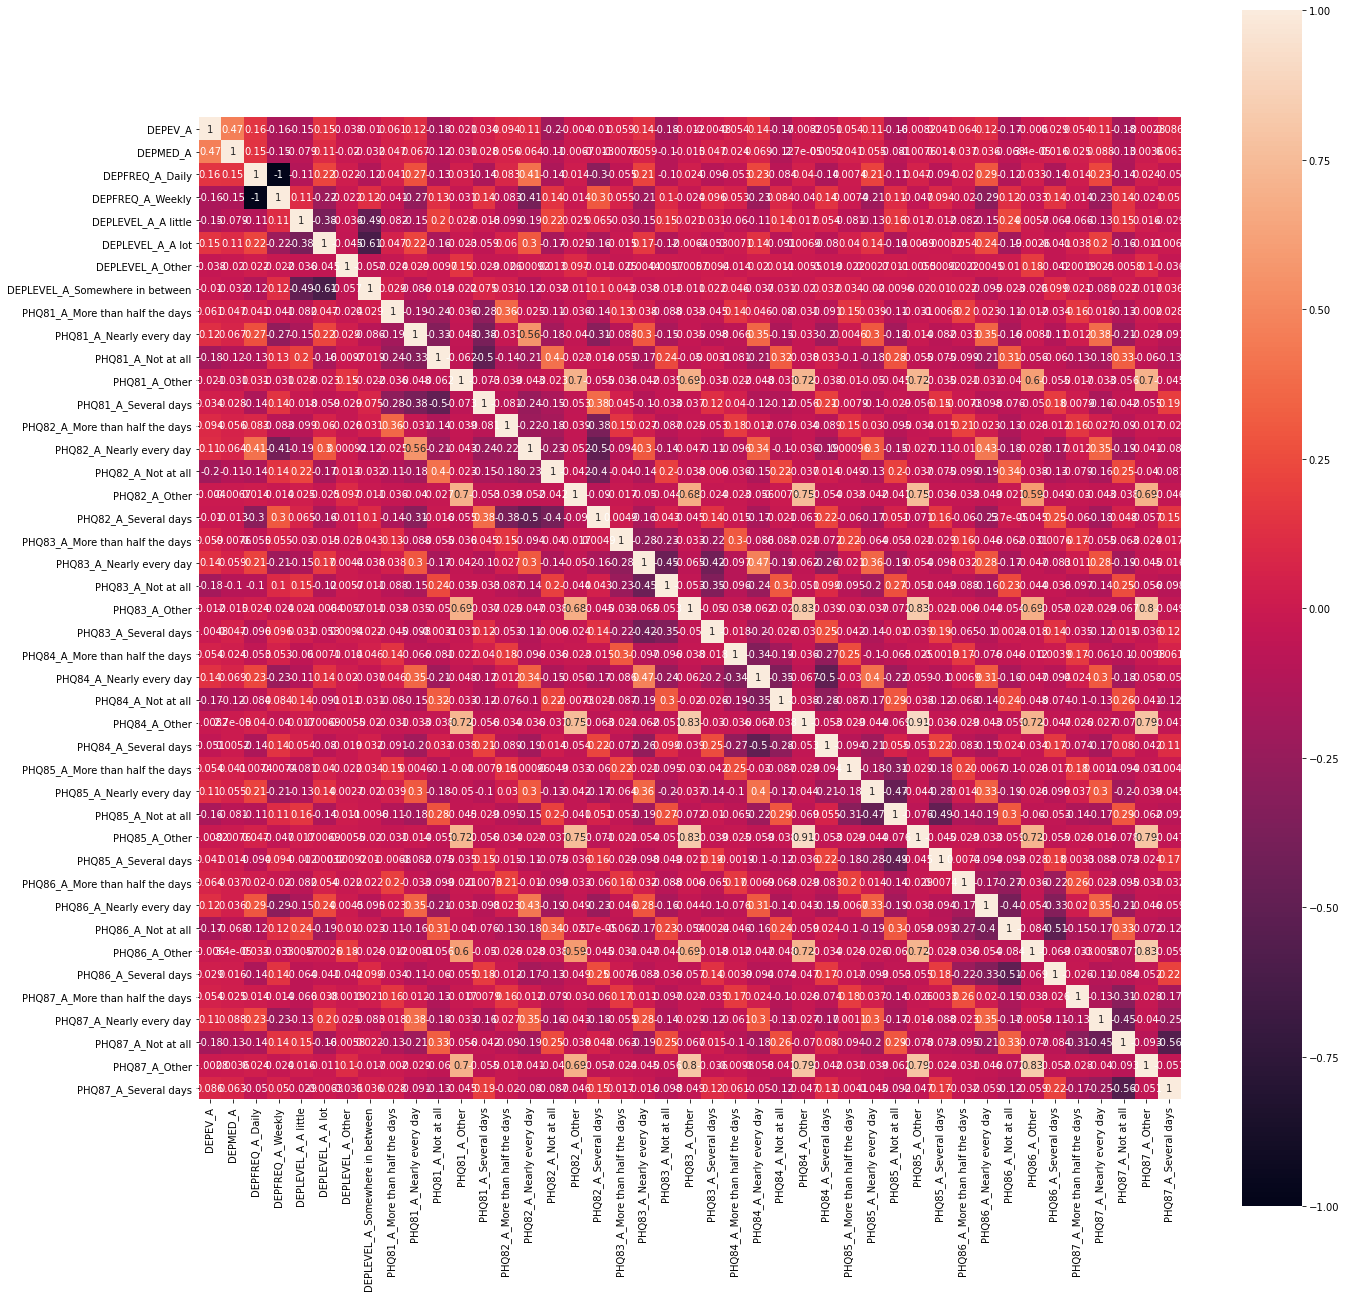

In [38]:
plt.figure(figsize=(22, 22))
sns.heatmap(df_depressed_core.corr(),square=True,annot=True)

As can be seen there is some stronger correlation between the other values of the phq question.  Because of this, I am going to drop these columns.  Most of the other values were small in number anyways.

In [40]:
others = ['PHQ81_A_Other','PHQ82_A_Other','PHQ83_A_Other', 'PHQ84_A_Other','PHQ85_A_Other','PHQ86_A_Other','PHQ87_A_Other']
df_depressed_core.drop(others,axis=1, inplace=True)

#  Visualizing the data using PCA and UMAP

In [41]:
X = df_depressed_core.values

Text(0.5, 1.0, 'UMAP')

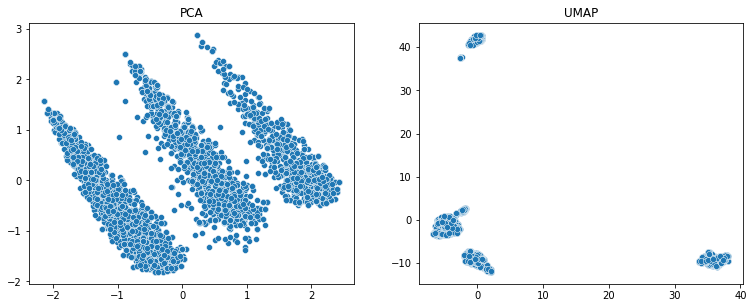

In [42]:
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

It looks like there may be 3 to 4 clusters.  

# Kmeans

The elbow occurs at 10


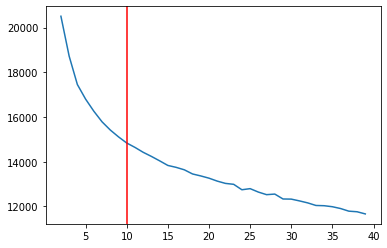

In [50]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

The elbow isn't apparent however Kneed calculates the elbow at 10

In [51]:
kmeans = KMeans(n_clusters=10, random_state=625)
preds = kmeans.fit_predict(X)
print("The silhouette score for 10 clusters is {}".format(silhouette_score(X,preds)))

The silhouette score for 10 clusters is 0.10283114481581261


The silouette score seems low, meaning clusters are mixing.  Below is a visualization.

<AxesSubplot:>

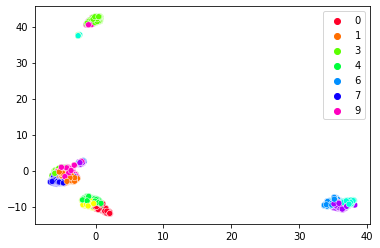

In [52]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

As you can see the clusters are mixed together.  Going to try dbscan.

# DBSCAN

In [53]:
df_depressed_core.shape[1]

36

DBSCAN has two main parameters, eps and min samples.  According to the Analytics Vidhya blog post, min samples should be at least one more than the number of parameters.  Other blogs suggest two times the number of parameters.  I am going to try values in the range of 37 to 80 in incriments of 3.  Next I need to find the best epsilon values for these min samples.  From the same article, the best epsilon is found using the K_neighbors_graph.  The medium article shows how to plot the k_neighbors graph to determine eps. 

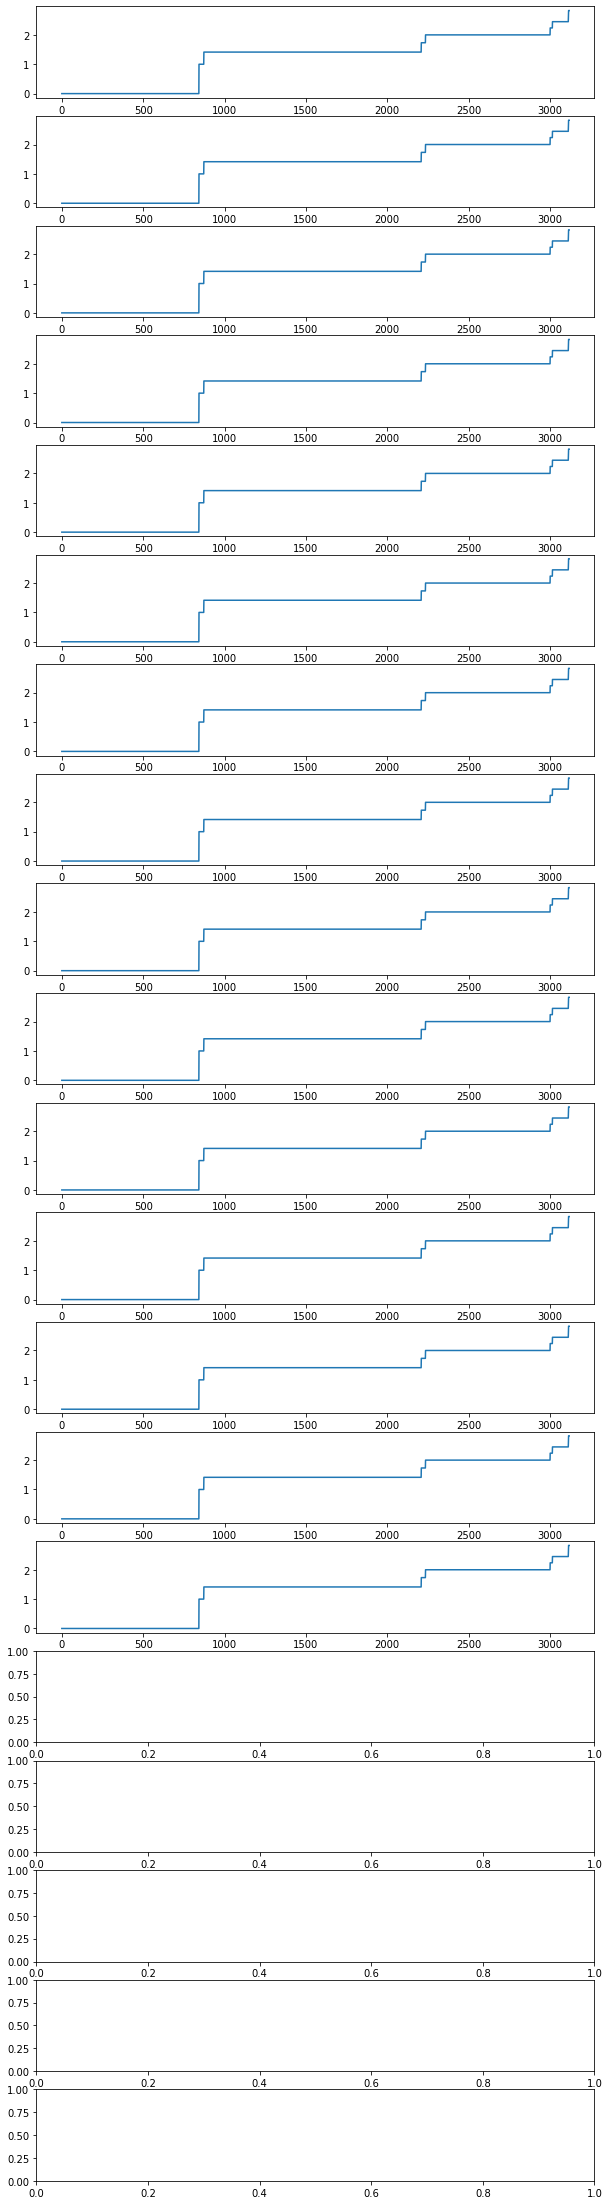

In [54]:
fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(10,40))
i = 0
for k in range(37,80,3):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    axs[i].plot(distances)
    i+=1
    
    

As each graph looks similar, I am going to plot for 20 neighbors and increase the plot size

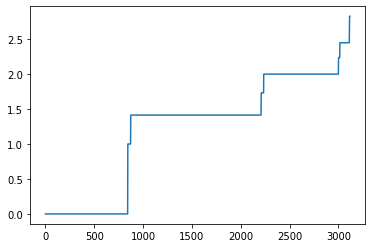

In [55]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [56]:
len(distances)

3118

# I am here

For each of these the knee appears between 1 and 2.  Going to try a knee of 1.5 then find which min samples produces the best silhouette score.  Finally adjust eps to find the best eps.

In [41]:
for min_samples in range(46,125,4):
    db = DBSCAN(eps=1.5, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass
    

The silhouette score for min_samples of 46 is 0.5654560242761763
The silhouette score for min_samples of 50 is 0.5910900054115834
The silhouette score for min_samples of 54 is 0.5985963676383345
The silhouette score for min_samples of 58 is 0.6117640688499126
The silhouette score for min_samples of 62 is 0.6232763389282504
The silhouette score for min_samples of 66 is 0.628815347104023
The silhouette score for min_samples of 70 is 0.6343045887891513
The silhouette score for min_samples of 74 is 0.6459677699316486
The silhouette score for min_samples of 78 is 0.6459677699316486
The silhouette score for min_samples of 82 is 0.6668417868065549
The silhouette score for min_samples of 86 is 0.6668417868065549


After a value of 82, there is no difference in silhouette score.

Going to now try to find the best eps with min_samples = 82

In [42]:
for eps in np.linspace(1.25, 1.75,20):
    db = DBSCAN(eps=eps, min_samples=82)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

The silhouette score for eps 1.4342105263157894 is 0.6668417868065549
The silhouette score for eps 1.4605263157894737 is 0.6668417868065549
The silhouette score for eps 1.486842105263158 is 0.6668417868065549
The silhouette score for eps 1.513157894736842 is 0.6668417868065549
The silhouette score for eps 1.5394736842105263 is 0.6668417868065549
The silhouette score for eps 1.5657894736842106 is 0.6668417868065549
The silhouette score for eps 1.5921052631578947 is 0.6668417868065549
The silhouette score for eps 1.618421052631579 is 0.6668417868065549
The silhouette score for eps 1.6447368421052633 is 0.6668417868065549
The silhouette score for eps 1.6710526315789473 is 0.6668417868065549
The silhouette score for eps 1.6973684210526314 is 0.6668417868065549
The silhouette score for eps 1.7236842105263157 is 0.6668417868065549
The silhouette score for eps 1.75 is 0.6668417868065549


None of these made a difference.  Going to keep 1.5 as eps and 82 as min samples

In [43]:
db = DBSCAN(eps = 1.5, min_samples = 82)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [44]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2888,  143,   87], dtype=int64))

In [45]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.6668417868065549


The silhouette score is high for two clusters.  
According to this paper, the amount of noise should be between 1 and 30 percent.  Here the amount of noice is over 90 percent.  Both Kmeans and Dbscan did not produce good clusters.  To try to improve the clusters, I am going to add more information to the data.  
  
Depression effects women more than men.  So first I am adding general demographics.

# Looking at demographics

In [46]:
demographics = ['AGEP_A','SEX_A','MARITAL_A', 'FAMINCTC_A','EDUC_A','EMPWRKLSWK_A','RACEALLP_A','HISP_A']
depressed_demo = df_depressed[demographics].copy()

AGEP_A contains the age of the adult individual.

<AxesSubplot:>

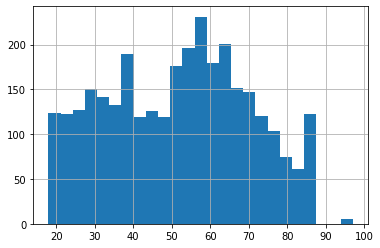

In [47]:
depressed_demo.AGEP_A.hist(bins=25)

From the histogram you can see adults of all ages struggle with depression.  The peaks are right before 40 and between 50 and 65.

SEX_A contains the gender of the adult.

<AxesSubplot:xlabel='SEX_A', ylabel='count'>

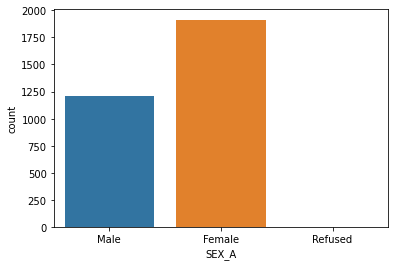

In [48]:
labels = {1:'Male',2:'Female',7:'Refused',8:'Not Ascertained',9:"Don't Know"}
depressed_demo.SEX_A.replace(labels,inplace=True)
sns.countplot(x='SEX_A',data=depressed_demo)

Notice there are more females than males.

MARITAL_A lists the marital status of the adult.

<AxesSubplot:xlabel='MARITAL_A', ylabel='count'>

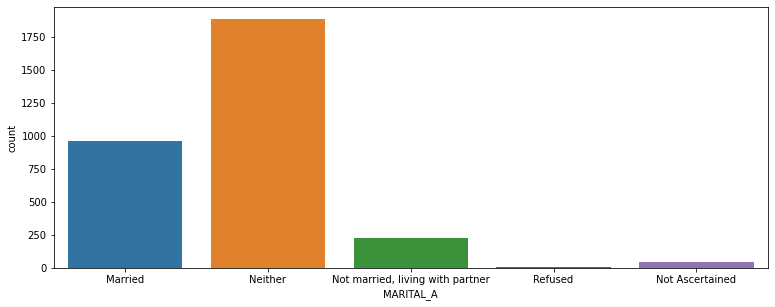

In [49]:
labels = {1:'Married',2:'Not married, living with partner',3:'Neither',7:'Refused',8:'Not Ascertained',9:"Don't Know"}
depressed_demo.MARITAL_A.replace(labels,inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='MARITAL_A',data=depressed_demo)

Most are not married and not living with a partner.

Going to combine refuesd and not ascertained into an other column.

In [50]:
labels = {'Refused':'Other','Not Ascertained':'Other'}
depressed_demo.MARITAL_A.replace(labels,inplace=True)

FAMINCTC_A has the family income.

<AxesSubplot:>

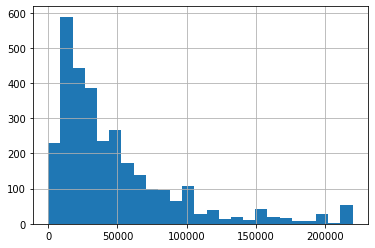

In [51]:
depressed_demo.FAMINCTC_A.hist(bins=25)

Most of those depressed have lower income.

EDUC_A has the education level of the adult.

<AxesSubplot:xlabel='count', ylabel='EDUC_A'>

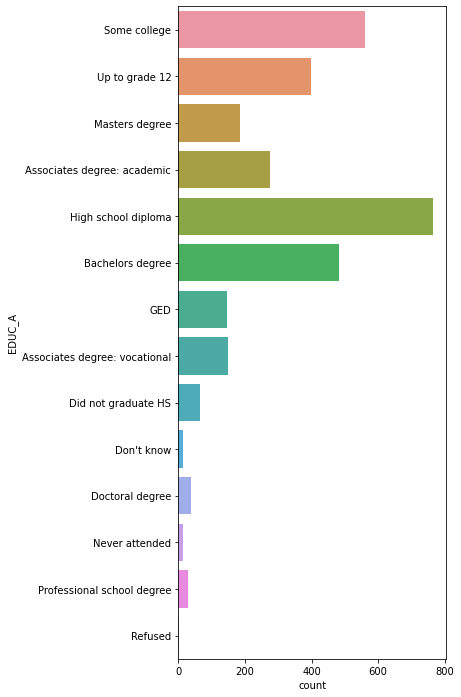

In [52]:
labels = {0:'Never attended',1:'Up to grade 12',2:'Did not graduate HS',3:'GED',4:'High school diploma',5:'Some college',
          6:'Associates degree: vocational',7:'Associates degree: academic',8:'Bachelors degree',9:'Masters degree',
         10:'Professional school degree',11:'Doctoral degree',97:'Refused',98:'Not ascertained',99:"Don't know"}

depressed_demo.EDUC_A.replace(labels,inplace=True)
plt.figure(figsize=(4.8, 12))
sns.countplot(y='EDUC_A',data=depressed_demo)

For those with depression, the most have a high school diploma.  Since there are many woth few counts, I am going to combine some buckets.

In [53]:
labels = {'Refused':'Other','Never attended':'Other',"Don't know":'Other','Masters degree':'Graduate school complete',
         'Professional school degree':'Graduate school complete','Doctoral degree':'Graduate school complete',
         'Did not graduate HS':'Up to grade 12','Associates degree: academic':'Associates degree',
         'Associates degree: vocational':'Associates degree','GED':'High school diploma'}
depressed_demo.EDUC_A.replace(labels,inplace=True)

In [54]:
depressed_demo.EMPWRKLSWK_A.unique()

array([1, 2, 9], dtype=int64)

EMPWRKLSWK_A denotes whether the adult worked last week.  With 1, yes, 2, no, and 9: don't know.

<AxesSubplot:xlabel='EMPWRKLSWK_A', ylabel='count'>

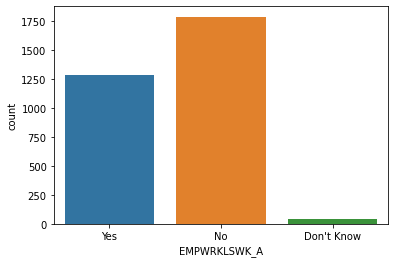

In [55]:
labels = {1:'Yes',2:'No',9:"Don't Know"}
depressed_demo.EMPWRKLSWK_A.replace(labels,inplace=True)
sns.countplot(x='EMPWRKLSWK_A',data=depressed_demo)

For those depressed, most did not work the past week.  I am going to replace yes with 1, no with -1 and don't know with 0

In [56]:
labels = {'Yes':1,'No':-1,"Don't know":0}
depressed_demo.EMPWRKLSWK_A.replace(labels,inplace=True)

RACEALLP_A denotes single and multiple race groups.

In [57]:
depressed_demo.RACEALLP_A.unique()

array([1, 2, 5, 8, 3, 4, 6], dtype=int64)

1: White only
2: Black/African American only
3: Asian only
4: American indian only
5: American indian and any other group
6: Other single and multiple races
8: Not ascertained

<AxesSubplot:xlabel='count', ylabel='RACEALLP_A'>

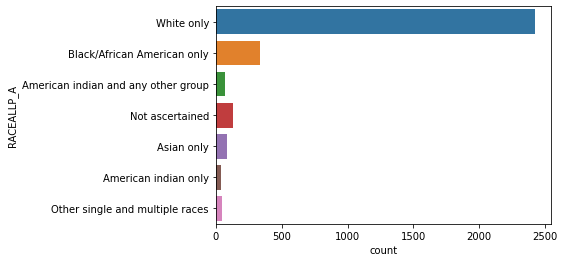

In [58]:
labels = {1: 'White only', 2: 'Black/African American only', 3: 'Asian only', 4: 'American indian only', 
          5: 'American indian and any other group', 6: 'Other single and multiple races', 8: 'Not ascertained'}
depressed_demo.RACEALLP_A.replace(labels, inplace=True)
sns.countplot(y='RACEALLP_A',data=depressed_demo)

For those with depression, the most are white.  However 75% of the respondents were white so nothing can be inferred.  I'm going tp combine the two american indian as well as other races and not ascertained.  Because the majority is white, Iam going to drop this variable.

In [59]:

depressed_demo.drop('RACEALLP_A',axis=1, inplace=True)

HISP_A asks about hispanic ethnicity

In [60]:
depressed_demo.HISP_A.unique()

array([2, 1], dtype=int64)

1: Yes
2: No

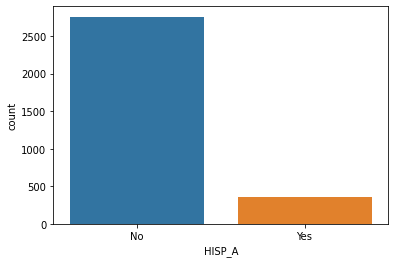

In [61]:
labels = {1:'Yes',2:'No'}
depressed_demo.HISP_A.replace(labels,inplace=True)
sns.countplot(x='HISP_A',data=depressed_demo)
labels={'Yes':1,'No':-1}
depressed_demo.HISP_A.replace(labels,inplace=True)

The majority of those with depression are not Hispanic.
Again I am going to drop this variable.

In [62]:
depressed_demo.drop('HISP_A',axis=1, inplace=True)

Standardizing the two non-ordinal variables...

In [63]:
depressed_demo.FAMINCTC_A = (depressed_demo.FAMINCTC_A - depressed_demo.FAMINCTC_A.mean())/depressed_demo.FAMINCTC_A.std()
depressed_demo.AGEP_A = (depressed_demo.AGEP_A-depressed_demo.AGEP_A.mean())/depressed_demo.AGEP_A.std()
df_depressed_demo = pd.get_dummies(depressed_demo)

In [64]:
df_depressed_democore = pd.concat([df_depressed_demo,df_depressed_core],axis=1)

In [65]:
df_depressed_democore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AGEP_A                                      3118 non-null   float64
 1   FAMINCTC_A                                  3118 non-null   float64
 2   SEX_A_Female                                3118 non-null   uint8  
 3   SEX_A_Male                                  3118 non-null   uint8  
 4   SEX_A_Refused                               3118 non-null   uint8  
 5   MARITAL_A_Married                           3118 non-null   uint8  
 6   MARITAL_A_Neither                           3118 non-null   uint8  
 7   MARITAL_A_Not married, living with partner  3118 non-null   uint8  
 8   MARITAL_A_Other                             3118 non-null   uint8  
 9   EDUC_A_Associates degree                    3118 non-null   uint8  
 10  EDUC_A_Bach

# Visualizing the dataset

In [66]:
X = df_depressed_democore.values

Text(0.5, 1.0, 'UMAP')

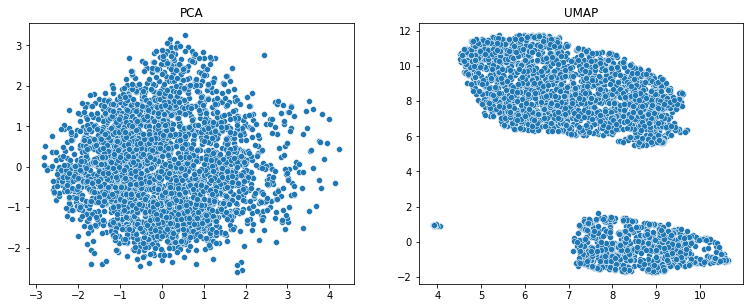

In [67]:
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

PCA appears dense, no visible clustering, while UMAP shows 2 possible clusters.  Although a lot of information is lost as you are going from 76 features to 2.  Trying kmeans...

<AxesSubplot:>

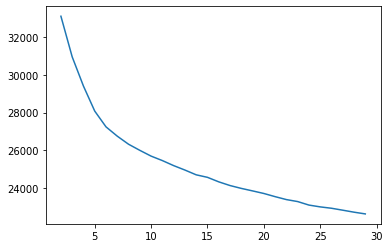

In [68]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

Again there is no apparent elbow, maybe around 13.

In [69]:
for n in range(5,26):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.08101123996743355
The silhouette score for 6 clusters is 0.08050108006798032
The silhouette score for 7 clusters is 0.07397764988912556
The silhouette score for 8 clusters is 0.067653257139756
The silhouette score for 9 clusters is 0.0667234830677863
The silhouette score for 10 clusters is 0.062307123523676136
The silhouette score for 11 clusters is 0.06093014456953121
The silhouette score for 12 clusters is 0.05571603489622337
The silhouette score for 13 clusters is 0.0552211189055771
The silhouette score for 14 clusters is 0.05992279413611662
The silhouette score for 15 clusters is 0.05809685999483127
The silhouette score for 16 clusters is 0.052649570993142075
The silhouette score for 17 clusters is 0.054393365204088266
The silhouette score for 18 clusters is 0.053176443681387145
The silhouette score for 19 clusters is 0.05274852845622484
The silhouette score for 20 clusters is 0.054536796955840454
The silhouette score for 21 clusters is 0.05

Again the silhouette scores are close to 0, meaning clusters are mixed.  The silhouette score increases again at 19 clusters.  



Trying DBSCAN...

In [70]:
df_depressed_democore.shape[1]

64

With 64 features, the min_samples shoud be at least 65.  Going to try to find the best eps using values from 65 to 140 in increments of 4.

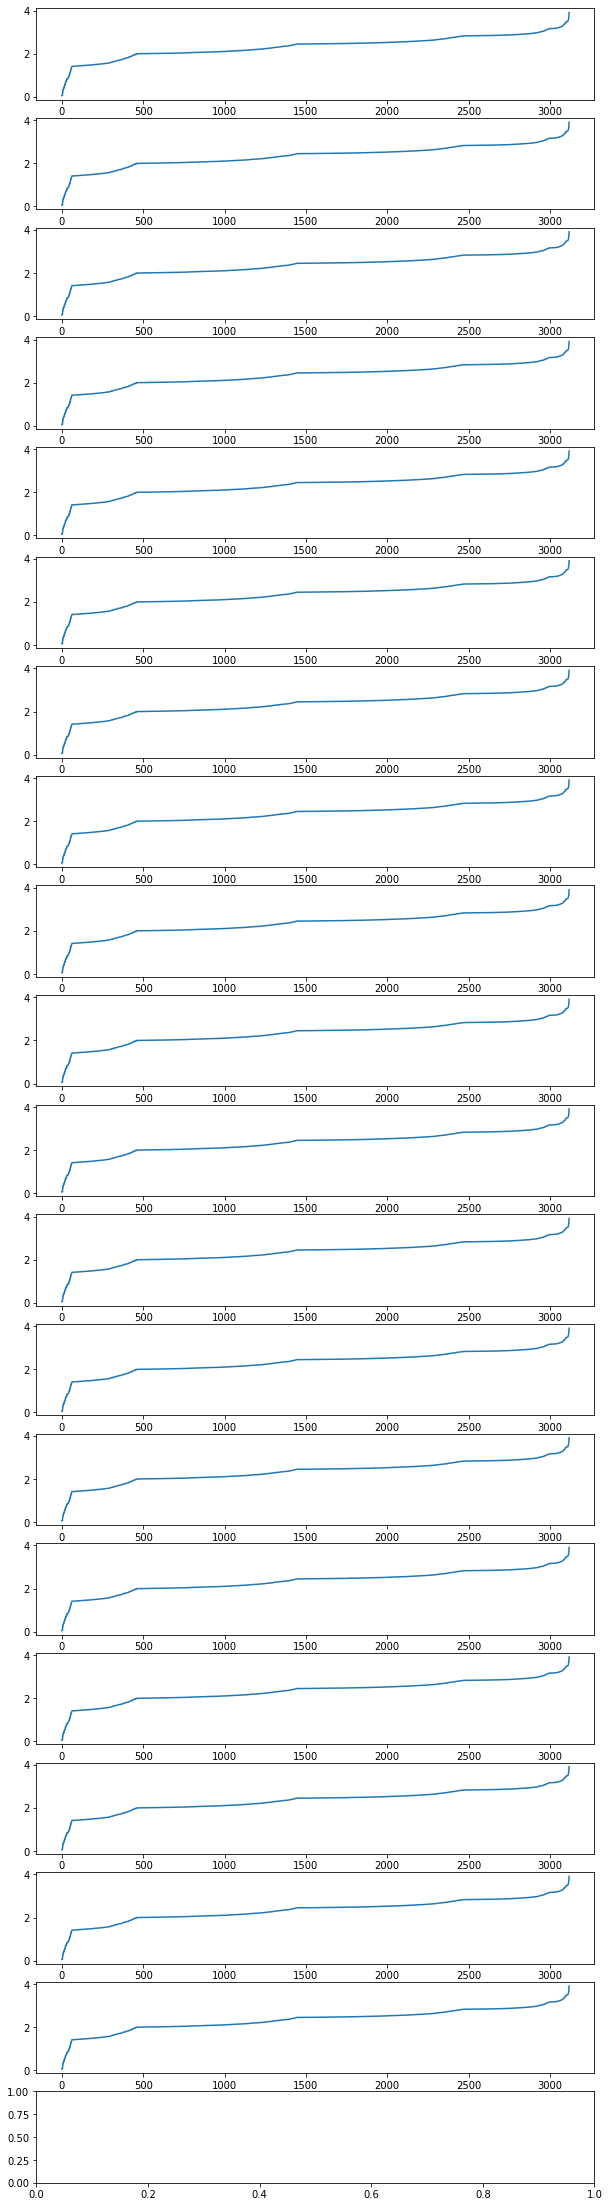

In [71]:
fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(10,40))
i = 0
for k in range(65,140,4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    axs[i].plot(distances)
    i+=1

Here epsilon looks at around 1.75 or 2.

In [72]:
for min_samples in range(65,140,4):
    db = DBSCAN(eps=1.75, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

In [73]:
db = DBSCAN(eps=1.75, min_samples = 77)
preds = db.fit_predict(X)
preds.max()

-1

Unfortunately this predicts everything as an outlier.  I'm going to increase eps to 3 and reduce min_samples to 50.

In [74]:
db = DBSCAN(eps=3, min_samples = 50)
preds = db.fit_predict(X)
preds.max()

0

Increasing eps and reducing min_samples produced 1 cluster.  Going to now try using the the demographics dataframe

Text(0.5, 1.0, 'UMAP')

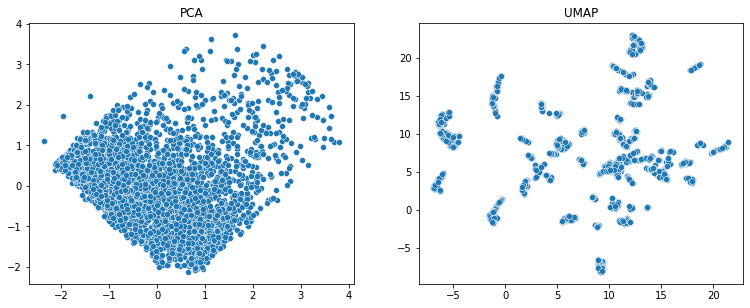

In [75]:
X = df_depressed_demo.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

UMAP shows some clustering.

<AxesSubplot:>

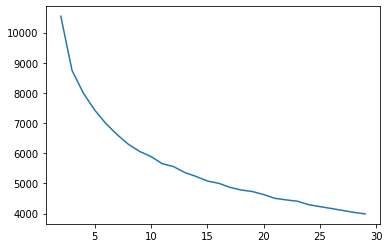

In [76]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

There is no pronounced elbow but may be an elbow around 15 or 20

In [77]:
for n in range(5,26):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.1714469129102631
The silhouette score for 6 clusters is 0.17089373474277614
The silhouette score for 7 clusters is 0.17927456915822274
The silhouette score for 8 clusters is 0.1746047655317058
The silhouette score for 9 clusters is 0.17534845329561766
The silhouette score for 10 clusters is 0.1805885578213027
The silhouette score for 11 clusters is 0.162160816421739
The silhouette score for 12 clusters is 0.18252412937654205
The silhouette score for 13 clusters is 0.17114209504737277
The silhouette score for 14 clusters is 0.17185344092190635
The silhouette score for 15 clusters is 0.1747276489390404
The silhouette score for 16 clusters is 0.17085485097851136
The silhouette score for 17 clusters is 0.17372707909287977
The silhouette score for 18 clusters is 0.18750226094177522
The silhouette score for 19 clusters is 0.1958884608017366
The silhouette score for 20 clusters is 0.18531615469166696
The silhouette score for 21 clusters is 0.1969701617

The best silhouette score is for 24 clusters, now going to try DBSCAN

In [78]:
df_depressed_demo.shape[1]

19

With 19 features there should be at least min_clusters 20.  Going to look for eps with n_neighors = 30

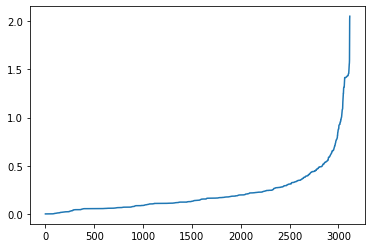

In [79]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

There is a knee around 0.5

In [80]:
for min_samples in range(20,61,2):
    db = DBSCAN(eps=0.5, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

The silhouette score for min_samples of 20 is 0.46622407439730384
The silhouette score for min_samples of 22 is 0.490967530155468
The silhouette score for min_samples of 24 is 0.527821801385036
The silhouette score for min_samples of 26 is 0.524257816944555
The silhouette score for min_samples of 28 is 0.5301349245090369
The silhouette score for min_samples of 30 is 0.5444576177572431
The silhouette score for min_samples of 32 is 0.5484892962154625
The silhouette score for min_samples of 34 is 0.5606907329360281
The silhouette score for min_samples of 36 is 0.5671145104318509
The silhouette score for min_samples of 38 is 0.5510530573271946
The silhouette score for min_samples of 40 is 0.5329314587951879
The silhouette score for min_samples of 42 is 0.5408320002994522
The silhouette score for min_samples of 44 is 0.5501558397936499
The silhouette score for min_samples of 46 is 0.562657805699458
The silhouette score for min_samples of 48 is 0.567524162168149
The silhouette score for min_

The best silhouette score is at 60 min samples.  However I would like to try 36 samples as 60 is more than 2 times the number of features.  36 is a point where the silhouettte score increased again.

In [81]:
for eps in np.linspace(0.25, 0.75,51):
    db = DBSCAN(eps=eps, min_samples=36)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

The silhouette score for eps 0.3 is 0.5603866832084907
The silhouette score for eps 0.31 is 0.5415239106247751
The silhouette score for eps 0.32 is 0.5331263280778746
The silhouette score for eps 0.36 is 0.5850417357681097
The silhouette score for eps 0.37 is 0.5989015188776027
The silhouette score for eps 0.38 is 0.5931477358712479
The silhouette score for eps 0.39 is 0.5818263812146772
The silhouette score for eps 0.4 is 0.5781457303567263
The silhouette score for eps 0.41000000000000003 is 0.5743880887389617
The silhouette score for eps 0.42000000000000004 is 0.5725307464816646
The silhouette score for eps 0.43 is 0.5664185295034958
The silhouette score for eps 0.44 is 0.5575822196067886
The silhouette score for eps 0.45 is 0.5582361858663103
The silhouette score for eps 0.45999999999999996 is 0.5571706546808705
The silhouette score for eps 0.47 is 0.5648216862624837
The silhouette score for eps 0.48 is 0.515552599253033
The silhouette score for eps 0.49 is 0.5364742757575676
The si

The best eps is 0.37

In [82]:
db = DBSCAN(eps = 0.37, min_samples = 36)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [83]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2903,  157,   58], dtype=int64))

Still more than 90% noise.

The NHIS survey also contains information on substance absuse.  I'm going to add that next to see if I can cluster the data.

# Looking at substance abuse

In [84]:
substances = ['OPD12M_A','SMKNOW_A','ECIGNOW_A']
df_substances = df_depressed[substances].copy()

In [85]:
df_substances.isnull().sum()

OPD12M_A      452
SMKNOW_A     1481
ECIGNOW_A    2310
dtype: int64

In [86]:
df_depressed.shape[0]

3118

Over a third of the dataset is null for smoking and electronic cigarettes.  I'm going to skip including substance abuse.

Next I'm going to look at chronic conditions

# Looking at Chronic Conditions

In [91]:
# diabetes may be null, might want to use PREDIB_A
conditions = ['HYPEV_A','CHLEV_A','ASEV_A','CANEV_A','DIBEV_A','COPDEV_A']
df_conditions = df_depressed[conditions].copy()
df_conditions.isnull().sum()

HYPEV_A     0
CHLEV_A     0
ASEV_A      0
CANEV_A     0
DIBEV_A     0
COPDEV_A    0
dtype: int64

HYPEV_A asks if you have ever been told you have hypertension. The respnses are 1: yes, 2: no, 7: refused, 8: not ascertained and 9: don't know.

<AxesSubplot:xlabel='HYPEV_A', ylabel='count'>

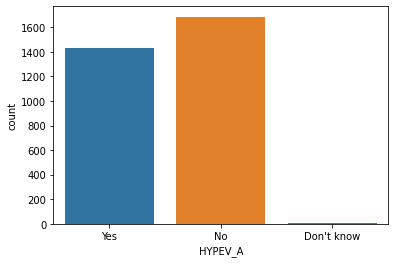

In [92]:
labels_yn = {1: 'Yes', 2: "No", 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
df_conditions.HYPEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='HYPEV_A', data=df_conditions)

Goint to replace yes with 1, no wth -1 and don't know with 0

In [93]:
labels_yn_r = {'Yes':1,'No':-1,"Don't know":0,"Refused":0, "Not ascertained" : 0}
df_conditions.HYPEV_A.replace(labels_yn_r, inplace=True)

CHLEV_A asks if the adult has ever had high cholesterol.

<AxesSubplot:xlabel='CHLEV_A', ylabel='count'>

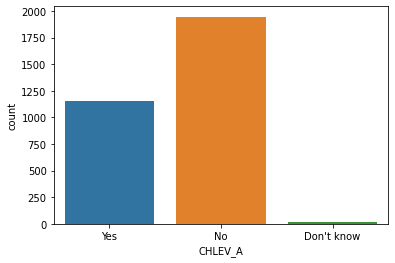

In [94]:
df_conditions.CHLEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='CHLEV_A', data=df_conditions)

In [95]:
df_conditions.CHLEV_A.replace(labels_yn_r, inplace=True)

ASEV_A asks if you have ever been told by a doctor you have asthma

<AxesSubplot:xlabel='ASEV_A', ylabel='count'>

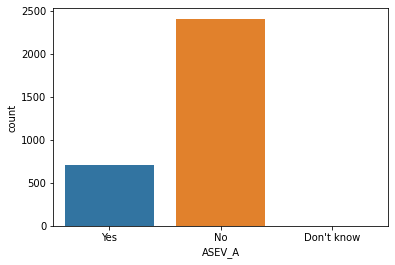

In [96]:
df_conditions.ASEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='ASEV_A', data=df_conditions)


In [97]:
df_conditions.ASEV_A.replace(labels_yn_r, inplace=True)

CANEV_A asks if you have ever been told you have cancer.

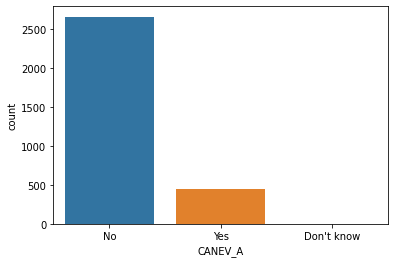

In [98]:
df_conditions.CANEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='CANEV_A', data=df_conditions)
df_conditions.CANEV_A.replace(labels_yn_r, inplace=True)

DIBEV_A asks if you have ever been told by a doctor you have diabetes.

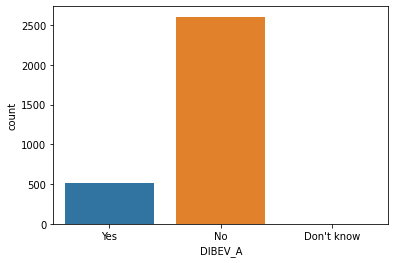

In [99]:
df_conditions.DIBEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='DIBEV_A', data=df_conditions)
df_conditions.DIBEV_A.replace(labels_yn_r, inplace=True)


COPDEV_A asks if you have ever been told by a doctor you have COPD, emphysema, or chronic bronchitis.

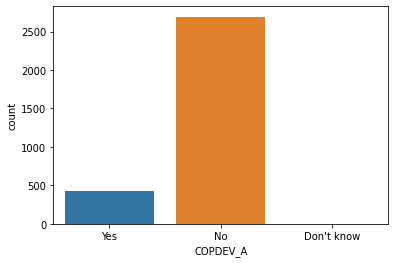

In [100]:
df_conditions.COPDEV_A.replace(labels_yn, inplace=True)
sns.countplot(x='COPDEV_A', data=df_conditions)
df_conditions.COPDEV_A.replace(labels_yn_r, inplace=True)

Looking at chronic conditions

Text(0.5, 1.0, 'UMAP')

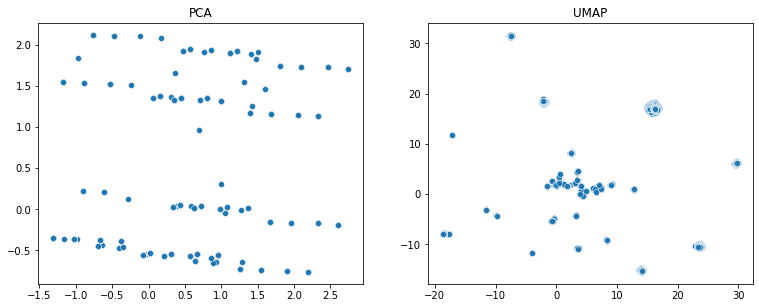

In [101]:
X = df_conditions.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

Both images show clustering of data.

<AxesSubplot:>

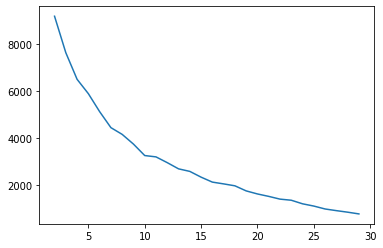

In [102]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

There is a definite knew around 10.

In [103]:
for n in range(5,26):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.4763961407312722
The silhouette score for 6 clusters is 0.5151978802852543
The silhouette score for 7 clusters is 0.5352866900286228
The silhouette score for 8 clusters is 0.5528651131287772
The silhouette score for 9 clusters is 0.5888660013649344
The silhouette score for 10 clusters is 0.6120415588976597
The silhouette score for 11 clusters is 0.6328873484468521
The silhouette score for 12 clusters is 0.6539969471769325
The silhouette score for 13 clusters is 0.6578014872032447
The silhouette score for 14 clusters is 0.6829042154819108
The silhouette score for 15 clusters is 0.7022494120569149
The silhouette score for 16 clusters is 0.7209270202723519
The silhouette score for 17 clusters is 0.7359677687867818
The silhouette score for 18 clusters is 0.7419112027341964
The silhouette score for 19 clusters is 0.7569298643761304
The silhouette score for 20 clusters is 0.7788348354270214
The silhouette score for 21 clusters is 0.7883675439423858
Th

Using dbscan

In [119]:
df_conditions.shape[1]

6

Given only 6 features, the min samples should be 7 or more.  Going to try values from 7 to 15.  First, I am going to look at the kneighbors plot for min_samples of 10

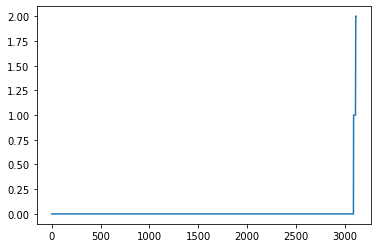

In [120]:
X = df_conditions.values
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Definitely a low value of eps, probably 0.05

In [121]:
for min_samples in range(7,16):
    db = DBSCAN(eps=0.05, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

The silhouette score for min_samples of 7 is 1.0
The silhouette score for min_samples of 8 is 1.0
The silhouette score for min_samples of 9 is 1.0
The silhouette score for min_samples of 10 is 1.0
The silhouette score for min_samples of 11 is 1.0
The silhouette score for min_samples of 12 is 1.0
The silhouette score for min_samples of 13 is 1.0
The silhouette score for min_samples of 14 is 1.0
The silhouette score for min_samples of 15 is 1.0


With all perfect silhouette scores, I'm assuming many outliers.   First I'll try with min_samples 7 and eps 0.05, then I'll increase the eps.

In [125]:
db = DBSCAN(eps = 0.05, min_samples = 7)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))
print('cluster sizes: ',np.unique(preds, return_counts=True))


The number of clusters selected by DBSCAN is 45
cluster sizes:  (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], dtype=int64), array([ 73,  34, 897, 298,  15, 178,   7, 224,  14,  35, 144,  34,  72,
        17,  76,  48,  41, 239,  72,  33,  25,  26,  11,  49,  16,  30,
        10,  13,  53,  29,  17,  54,  37,  22,  32,   7,  33,  18,  12,
        14,   9,   9,   9,  12,  12,   8], dtype=int64))


There are definitely many clusters and few outliers.  This is definitely a good clustering.  And it has a silhouette score of 1 so each is identical, in respect to chronic conditions.

In [127]:
silhouette_score(X[preds!=-1],preds[preds!=-1])

1.0

The silhouette score is perfect. There is clustering based on chronic conditions.  However since this doesn't include depression variables, it may just be clustering chronic conditions.  Going to concat depressed_core with df_conditions

In [104]:
df_core_conditions = pd.concat([df_depressed_core,df_conditions], axis=1)

Text(0.5, 1.0, 'UMAP')

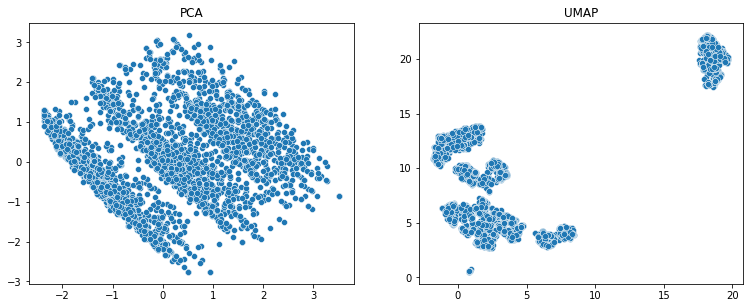

In [105]:
X = df_core_conditions.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

Here also there appears to be clustering.

<AxesSubplot:>

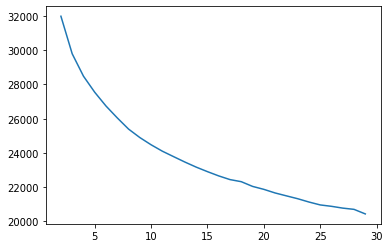

In [106]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

The elbow is not as pronounced but there may be an elbow at 17 or 26.

In [107]:
for n in range(5,30):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.08786704158224104
The silhouette score for 6 clusters is 0.08633332878380484
The silhouette score for 7 clusters is 0.0834582009103847
The silhouette score for 8 clusters is 0.08063690608143961
The silhouette score for 9 clusters is 0.08310077245786958
The silhouette score for 10 clusters is 0.07487051784627166
The silhouette score for 11 clusters is 0.0793948927275965
The silhouette score for 12 clusters is 0.07191756921991481
The silhouette score for 13 clusters is 0.07635216042257204
The silhouette score for 14 clusters is 0.06750891559403496
The silhouette score for 15 clusters is 0.06579986322628376
The silhouette score for 16 clusters is 0.0679620221744436
The silhouette score for 17 clusters is 0.06542364521186239
The silhouette score for 18 clusters is 0.05700907426435016
The silhouette score for 19 clusters is 0.068209744043845
The silhouette score for 20 clusters is 0.06678790737811394
The silhouette score for 21 clusters is 0.06576758

Combining depressed core and chronic conditions drops the silhouette values.  

Trying dbscan...

In [109]:
df_core_conditions.shape[1]

51

Since there are 51 features, the min samples must be at least 52.  Going to look at the kneighbors plot for 70 samples.

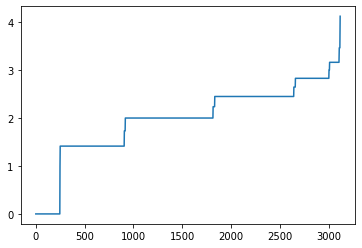

In [110]:
neighbors = NearestNeighbors(n_neighbors=70)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The elbow appears around 3.

In [114]:
for min_samples in range(52,130,4):
    db = DBSCAN(eps=3, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

The silhouette score for min_samples of 128 is 0.1540503335359361


Only more than one cluster appears when the min_samples is 128.

In [115]:
for eps in np.linspace(2.75, 3.75,51):
    db = DBSCAN(eps=eps, min_samples=128)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

The silhouette score for eps 2.83 is 0.15610204220409335
The silhouette score for eps 2.85 is 0.15610204220409335
The silhouette score for eps 2.87 is 0.15610204220409335
The silhouette score for eps 2.89 is 0.15610204220409335
The silhouette score for eps 2.91 is 0.15610204220409335
The silhouette score for eps 2.93 is 0.15610204220409335
The silhouette score for eps 2.95 is 0.15610204220409335
The silhouette score for eps 2.97 is 0.15610204220409335
The silhouette score for eps 2.99 is 0.15610204220409335
The silhouette score for eps 3.01 is 0.1540503335359361
The silhouette score for eps 3.0300000000000002 is 0.1540503335359361
The silhouette score for eps 3.05 is 0.1540503335359361
The silhouette score for eps 3.07 is 0.1540503335359361
The silhouette score for eps 3.09 is 0.1540503335359361
The silhouette score for eps 3.11 is 0.1540503335359361
The silhouette score for eps 3.13 is 0.1540503335359361
The silhouette score for eps 3.15 is 0.1540503335359361


After 2.83, the silhouette score drops.  Going to use 2.83 as epsilon and min_samples as 128.

In [116]:
db = DBSCAN(eps = 2.83, min_samples = 128)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [117]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([1738, 1153,  227], dtype=int64))

Notice there are a lot fewer outliers than seen before.

In [118]:
silhouette_score(X[preds!=-1],preds[preds!=-1])

0.15610204220409335